In [1]:
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from cifar import CifarDataset

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset = CifarDataset('./data/cifar-10-batches-py', device)

In [3]:
print(dataset.train_x.shape)
print(dataset.train_y.shape)
print(dataset.test_x.shape)
print(dataset.test_y.shape)

torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000, 3, 32, 32])
torch.Size([10000])


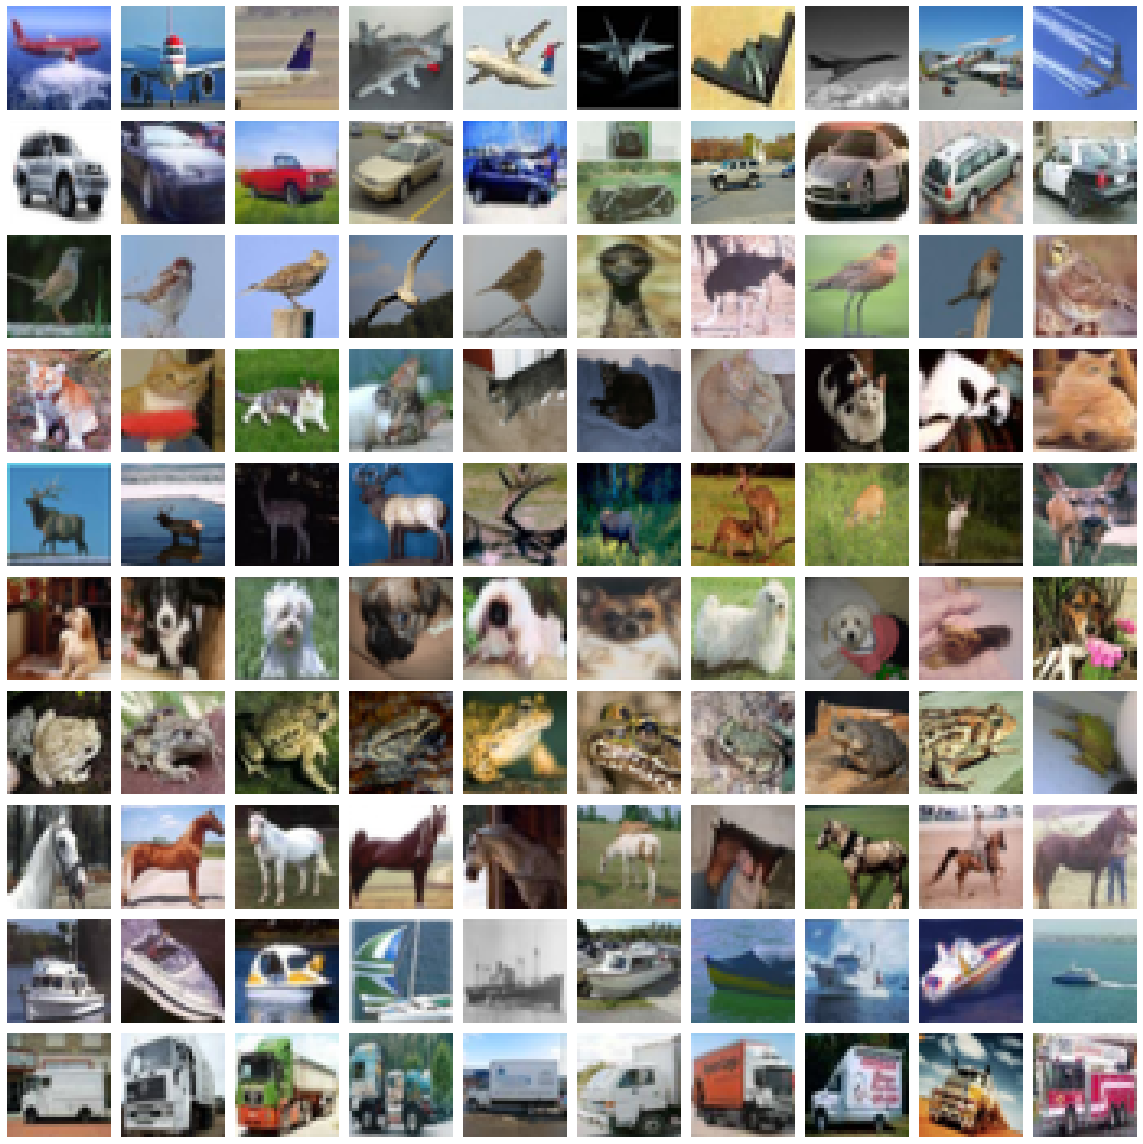

In [4]:
fig, ax = plt.subplots(10, 10, figsize=(16, 16))
ys = dataset.test_y
for label, plotrow in enumerate(ax):
    labex_idxes = torch.where(ys == label)[0]
    labex_idxes = labex_idxes.to('cpu')
    for plotcell in plotrow:
        plotcell.grid(False)
        plotcell.axis('off')
        idx = np.random.choice(labex_idxes)
        x = dataset.test_x[idx]
        plotcell.imshow(x.permute(1,2,0).to('cpu'))
plt.tight_layout()


In [20]:
model = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(32*32*3, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, 10)
)
model = model.to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
valds, testds = torch.utils.data.random_split(TensorDataset(dataset.test_x, dataset.test_y), [5000, 5000])
valdataloader = DataLoader(valds, batch_size=1000, shuffle=False)
testdataloader = DataLoader(testds, batch_size=1000, shuffle=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, threshold=0.0001, threshold_mode='rel',
    min_lr=1e-5, verbose=True)

In [24]:
def train_batch(x, y, model, opt, lossfn, regfn=None, regw=0.01):
    model.train() # switch model to trainning mode
    yp = model(x)
    loss = lossfn(yp, y)
    sample_loss = loss
    if regfn:
        loss = loss + regw * regfn(model)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return sample_loss.item()

@torch.no_grad()
def compute_loss(x, y, model, lossfn):
    model.eval()
    yp = model(x)
    loss = lossfn(yp, y)
    return loss.item()

def l1reg(model):
    reg = 0.0
    for param in model.parameters():
        reg += torch.norm(param, 1)
    return reg

def l2reg(model):
    reg = 0.0
    for param in model.parameters():
        reg += torch.norm(param, 2)
    return reg

In [25]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # switch model to eval mode
    yp = model(x)
    maxvals, maxidxes = yp.max(dim=1)
    is_correct = maxidxes == y
    return is_correct.to('cpu').numpy().tolist()


In [26]:
# training loop
import time
losses = []
val_losses = []
accuracies = []
val_accuracies = []

for epoch in range(120):
    start = time.time()
    epoch_losses = []
    epoch_accuracies = []
    val_epoch_losses = []
    val_epoch_accuracies = []
    for x, y in dataloader:
        loss = train_batch(x.view(len(x), -1), y, model, optimizer, lossfn, l2reg, 0.001)
        epoch_losses.append(loss)
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    for x, y in dataloader:
        is_currect = accuracy(x.view(len(x), -1), y, model)
        epoch_accuracies.extend(is_currect)
    epoch_accuracy = np.mean(epoch_accuracies)
    accuracies.append(epoch_accuracy)

    for x, y in valdataloader:
        loss = compute_loss(x.view(len(x), -1), y, model, lossfn)
        val_epoch_losses.append(loss)
    val_loss = np.mean(val_epoch_losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    for x, y in valdataloader:
        val_is_correct = accuracy(x.view(len(x), -1), y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_accuracy = np.mean(val_epoch_accuracies)
    val_accuracies.append(val_accuracy)
    end = time.time()
    print('epoch %d, consume %.2fs, train loss: %.4f, train acc: %.4f, val loss: %.4f, val acc: %.4f' %
          (epoch, end - start, epoch_loss, epoch_accuracy, val_loss, val_accuracy))

test_accuracies = []
for x, y in testdataloader:
    test_is_correct = accuracy(x.view(len(x), -1), y, model)
    test_accuracies.extend(test_is_correct)
test_accuracy = np.mean(test_accuracies)
print('final test acc: %.4f' % test_accuracy)
        

epoch 0, consume 5.38s, train loss: 1.8637, train acc: 0.3749, val loss: 1.7387, val acc: 0.3804
epoch 1, consume 5.25s, train loss: 1.6973, train acc: 0.3970, val loss: 1.6930, val acc: 0.3948
epoch 2, consume 5.35s, train loss: 1.6290, train acc: 0.4480, val loss: 1.5519, val acc: 0.4436
epoch 3, consume 5.50s, train loss: 1.5915, train acc: 0.4469, val loss: 1.5806, val acc: 0.4418
epoch 4, consume 5.24s, train loss: 1.5560, train acc: 0.4607, val loss: 1.5363, val acc: 0.4516
epoch 5, consume 5.14s, train loss: 1.5277, train acc: 0.4954, val loss: 1.4519, val acc: 0.4832
epoch 6, consume 5.08s, train loss: 1.5034, train acc: 0.4984, val loss: 1.4649, val acc: 0.4828
epoch 7, consume 5.06s, train loss: 1.4889, train acc: 0.4937, val loss: 1.4885, val acc: 0.4790
epoch 8, consume 5.10s, train loss: 1.4664, train acc: 0.5279, val loss: 1.4036, val acc: 0.5038
epoch 9, consume 5.19s, train loss: 1.4494, train acc: 0.5315, val loss: 1.3879, val acc: 0.5088
epoch 10, consume 5.13s, train

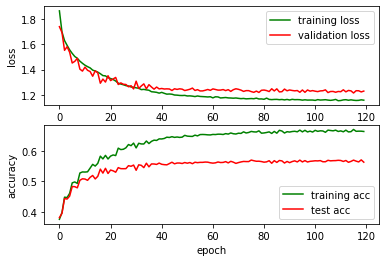

In [27]:
plt.subplot(2, 1, 1)
plt.plot(losses, 'g', label='training loss')
plt.plot(val_losses, 'r', label='validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(accuracies, 'g', label='training acc')
plt.plot(val_accuracies, 'r', label='test acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()